# $x^2$ potential

In [1]:
import pickle
import numpy as np
import pycuda.gpuarray as gpuarray
from scipy.special import hyp1f1
import scipy.fftpack as fftpack
import pylab as plt
import time

#-------------------------------------------------------------------------------------
from pywignercuda_path import SetPyWignerCUDA_Path
SetPyWignerCUDA_Path()
from GPU_Wigner2D_GPitaevskii import *

In [2]:
%matplotlib inline

## Settings

In [3]:
class frame( GPU_Wigner2D_GPitaevskii_Bloch ):
    def __init__ (self):
        X_gridDIM = 512
        P_gridDIM = 512
        
        X_amplitude  = 16
        P_amplitude  = 16
        
        hBar = 1.
        dt= 0.01
        
        timeSteps =    800
        skipFrames =   100
        
        mass = 1.      
                
        #Gross Pitaevskii coefficient
        self.GPitaevskiiCoeff = 1.
        
        # Potential and derivative of potential
        self.omega = 1.
        X2_constant = 0.5*mass*self.omega**2
        
        kinematicString  = '0.5*p*p/{mass}'.format(mass=mass)
        potentialString  = '{0}*pow(x,2)'.format(X2_constant)

        dPotentialString = '2*{0}*x'.format(X2_constant)
        
        self.SetTimeTrack( dt, timeSteps, skipFrames,
        fileName = '/home/rcabrera/DATA/Wigner2D_GPitaevskii/X2_Ground.hdf5' )
        
        GPU_Wigner2D_GPitaevskii_Bloch.__init__(self,
            X_gridDIM,P_gridDIM,X_amplitude,P_amplitude,hBar,mass,potentialString,kinematicString)
    
    
    def Set_Initial_Condition(self):
        """
        """
        self.W_init = np.exp( -self.X**2/20. - self.P**2/20.  )
        
        norm =  np.sum(self.W_init)*self.dX*self.dP
        
        self.W_init /= norm

## Run

In [4]:
instance = frame()
print '							'
print ' 	Wigner2D propagator with damping	'
print '							'

instance.Set_Initial_Condition ()

%time instance.Run( )

							
 	Wigner2D propagator with damping	
							
 X_gridDIM =  512    P_gridDIM =  512
 dx =  0.0625  dp =  0.0625
 dLambda =  0.196349540849  dTheta =  0.196349540849
  
         GPU memory Total        5.24945068359 GB
         GPU memory Free         4.72459030151 GB
Initial W Norm =  (1+0j)
         GPU memory Free  post gpu loading  4.71287155151 GB
 ------------------------------------------------------------------------------- 
     Split Operator Propagator  GPU with damping                                 
 ------------------------------------------------------------------------------- 
        
        
step  0
step  100
step  200
step  300
step  400
step  500
step  600
step  700
step  800
CPU times: user 6.77 s, sys: 3.88 s, total: 10.6 s
Wall time: 11.7 s


0

## Plots

Potential


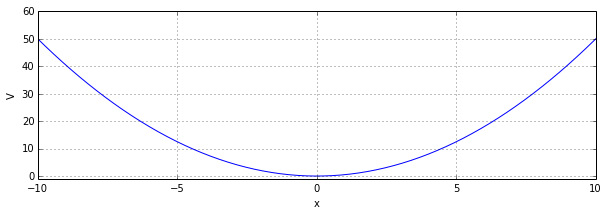

In [5]:
print 'Potential'
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot( instance.X_range,   instance.Potential(0,instance.X_range) )
ax.set_xlim(-10,10)
ax.set_ylim(-1,60)
ax.set_xlabel('x')
ax.set_ylabel('V')
ax.grid('on')

In [6]:
def PlotWignerFrame( W_input , x_plotRange,p_plotRange):
    W = W_input.copy()
    W = fftpack.fftshift(W.real)    
    
    dp    = instance.dP
    p_min = -instance.P_amplitude
    p_max =  instance.P_amplitude - dp   
    
    #p_min = -dp*instance.P_gridDIM/2.
    #p_max =  dp*instance.P_gridDIM/2. - dp    
    
    x_min = -instance.X_amplitude
    x_max =  instance.X_amplitude - instance.dX
    
    global_max = 0.17          #  Maximum value used to select the color range
    global_min = -0.31         # 
        
    print 'min = ', np.min( W ), ' max = ', np.max( W )
    print 'final time =', instance.timeRange[-1] ,'a.u.  =',\
    instance.timeRange[-1]*( 2.418884326505*10.**(-17) ) , ' s '
    
    print 'normalization = ', np.sum( W )*instance.dX*dp

    zero_position =  abs( global_min) / (abs( global_max) + abs(global_min)) 
    wigner_cdict = {'red' 	: 	((0., 0., 0.),
							(zero_position, 1., 1.), 
							(1., 1., 1.)),
					'green' :	((0., 0., 0.),
							(zero_position, 1., 1.),
							(1., 0., 0.)),
					'blue'	:	((0., 1., 1.),
							(zero_position, 1., 1.),
							(1., 0., 0.)) }
    wigner_cmap = matplotlib.colors.LinearSegmentedColormap('wigner_colormap', wigner_cdict, 256)

    fig, ax = plt.subplots(figsize=(12, 5))

    cax = ax.imshow( W ,origin='lower',interpolation='none',\
    extent=[ x_min , x_max, p_min, p_max], vmin= global_min, vmax=global_max, cmap=wigner_cmap)

    ax.contour(instance.Hamiltonian ,
                np.arange(0, 10, 1 ),origin='lower',extent=[x_min,x_max,p_min,p_max],
               linewidths=0.25,colors='k')
    
    axis_font = {'size':'24'}
    
    ax.set_xlabel(r'$x$',**axis_font)
    ax.set_ylabel(r'$p$',**axis_font)
    
    ax.set_xlim((x_plotRange[0] , x_plotRange[1] ))
    ax.set_ylim((p_plotRange[0] , p_plotRange[1] ))
    ax.set_aspect(1.)
    #ax.grid('on')
    cbar = fig.colorbar(cax, ticks=[-0.3, -0.2,-0.1, 0, 0.1, 0.2 , 0.3])
    matplotlib.rcParams.update({'font.size': 18})
    return fig

min =  1.21305854123e-13  max =  0.015915507691
final time = 8.0 a.u.  = 1.9351074612e-16  s 
normalization =  1.0


/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


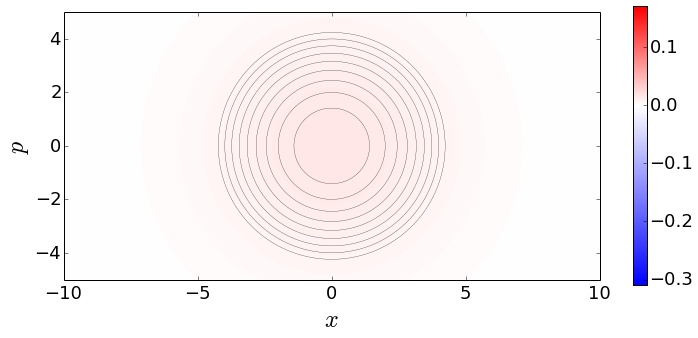

In [7]:
plot_init = PlotWignerFrame( instance.W_init.real , (-10.,10) ,(-5,5)  )


min =  -0.000683046801767  max =  0.317703452498
final time = 8.0 a.u.  = 1.9351074612e-16  s 
normalization =  1.0


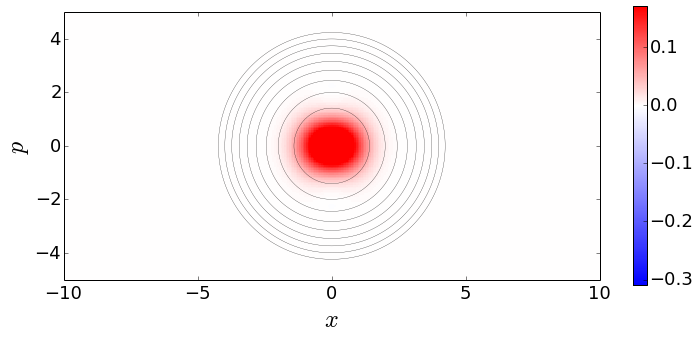

In [8]:
plot_init = PlotWignerFrame( instance.W_0 , (-10.,10) ,(-5,5)  )

In [9]:
def PlotMarginals():
    
    W = fftpack.fftshift( instance.W_0 )
    
    dp    = instance.dP
    p_min = -instance.P_amplitude
    p_max =  instance.P_amplitude - dp   
        
    W0 = fftpack.fftshift(instance.W_init  )
    
    marginal_x_init = np.sum(  W0 , axis=0 )*dp
    marginal_p_init = np.sum(  W0 , axis=1 )*instance.dX

    marginal_x = np.sum(  W, axis=0 )*dp
    marginal_p = np.sum(  W, axis=1 )*instance.dX


    x_min = -instance.X_amplitude
    x_max = instance.X_amplitude - instance.dX 
    #.......................................... Marginal in position

    plt.figure(figsize=(10,10))
    plt.subplot(211)

    plt.plot(instance.X_range, marginal_x_init, '-',label='initial')
    plt.plot(instance.X_range, marginal_x,  label='final')
    #plt.axis([x_min, 0*x_max, -0.01,6])
    plt.xlabel('x')
    plt.ylabel('Prob')

    plt.legend(loc='upper right', shadow=True)

    #..........................................  Marginal in momentum

    print 'p = ', np.sum( marginal_p*instance.P_range )*dp,\
    '->', np.sum( W*instance.P )*instance.dX*dp
    print 'x = ', np.sum( W0*instance.X )*instance.dX*dp, \
    '->',np.sum( W*instance.X )*instance.dX*dp
    
    rangeP = np.linspace( p_min, p_max, instance.P_gridDIM )
    
    plt.subplot(212)
    plt.plot(rangeP, marginal_p_init ,'-', label='initial')
    plt.plot(rangeP, marginal_p  , label='final')
    plt.axis([p_min, p_max, -0.01, 1])
    plt.xlabel('p')
    plt.ylabel('Prob')

    plt.legend(loc='upper right', shadow=True)

p =  -1.05471187339e-14 -> -0.608178395598
x =  -0.126156679138 -> -0.502753310047


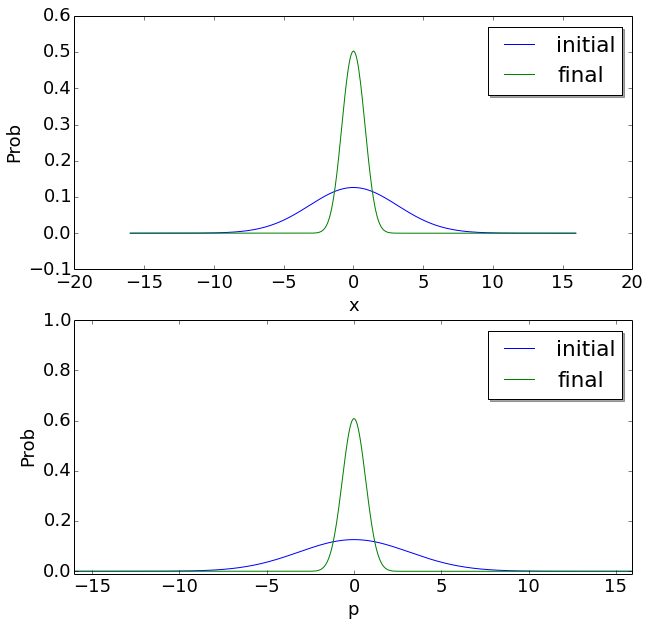

In [10]:
PlotMarginals()

## First Order Ehrenfest

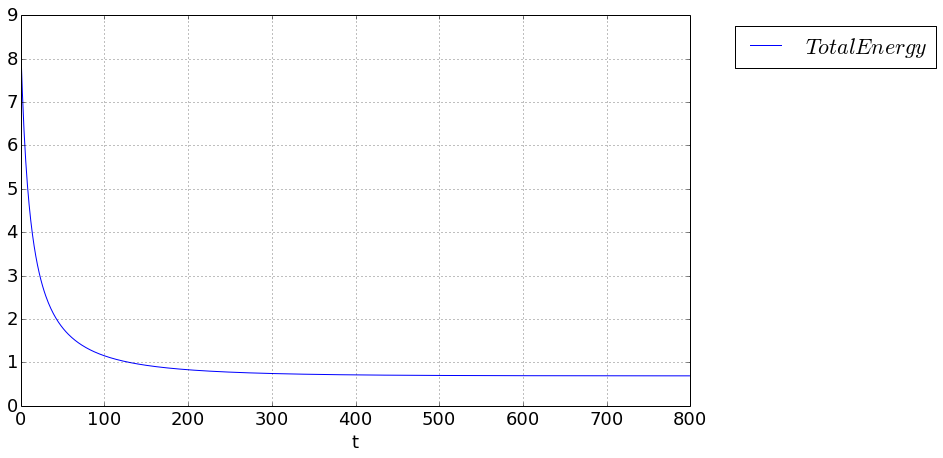

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot( instance.TotalEnergyHistory  ,
        '-' , label = '$Total Energy$' , linewidth=1.)



ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
ax.set_ylim( 0. , 9. )
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

In [12]:
instance.NonLinearEnergyHistory.shape

(800,)

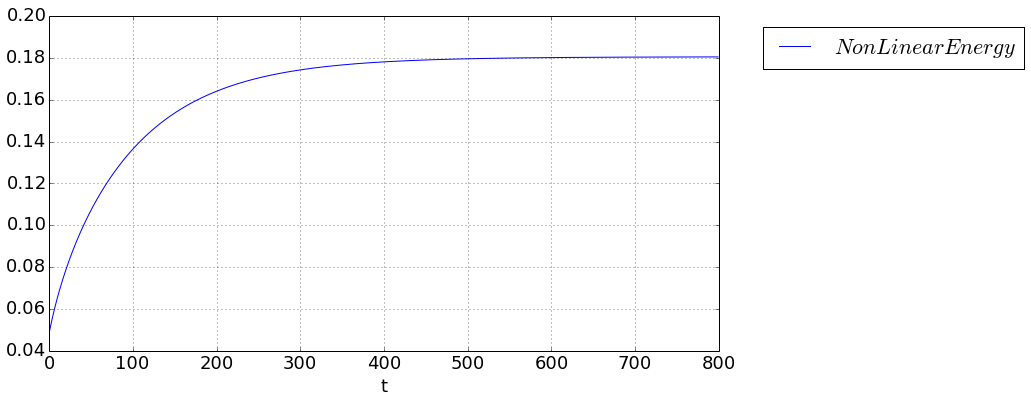

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(  instance.NonLinearEnergyHistory
        , '-' , label = '$Non Linear Energy$' , linewidth=1.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim( 1.19 , 1.21 )
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

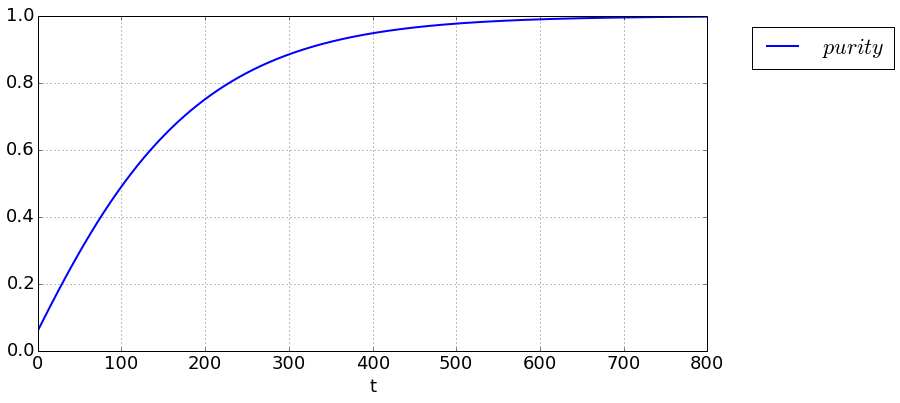

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(  instance.purity , '-' , label = '$purity $',linewidth=2.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim( 0.99 , 1.01 )
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

## First Exited state

In [15]:
%time instance.Run_ExitedState1( )

         GPU memory Total        5.24945068359 GB
         GPU memory Free         4.72068405151 GB
Initial W Norm =  (1+0j)
         GPU memory Free  post gpu loading  4.70505905151 GB
 ------------------------------------------------------------------------------- 
     Split Operator Propagator  GPU with damping                                 
 ------------------------------------------------------------------------------- 
        
        
step  0
step  100
step  200
step  300
step  400
step  500
step  600
step  700
dt =  0.01
dt =  0.005
dt =  0.0025
dt =  0.00125
step  800
CPU times: user 7.51 s, sys: 4.19 s, total: 11.7 s
Wall time: 11.9 s


0

min =  -0.303893689631  max =  0.18269849465
final time = 8.0 a.u.  = 1.9351074612e-16  s 
normalization =  1.0


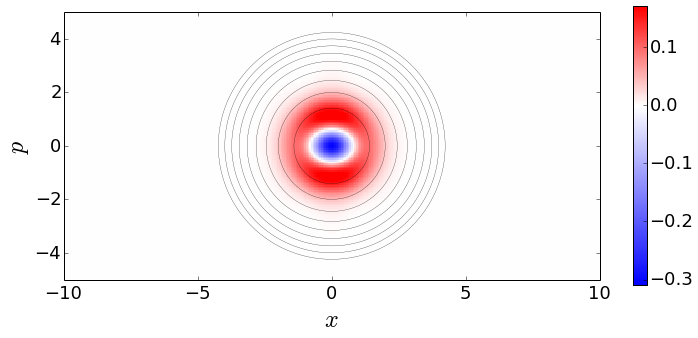

In [16]:
plot_init = PlotWignerFrame( instance.W_1 , (-10.,10) ,(-5,5)  )

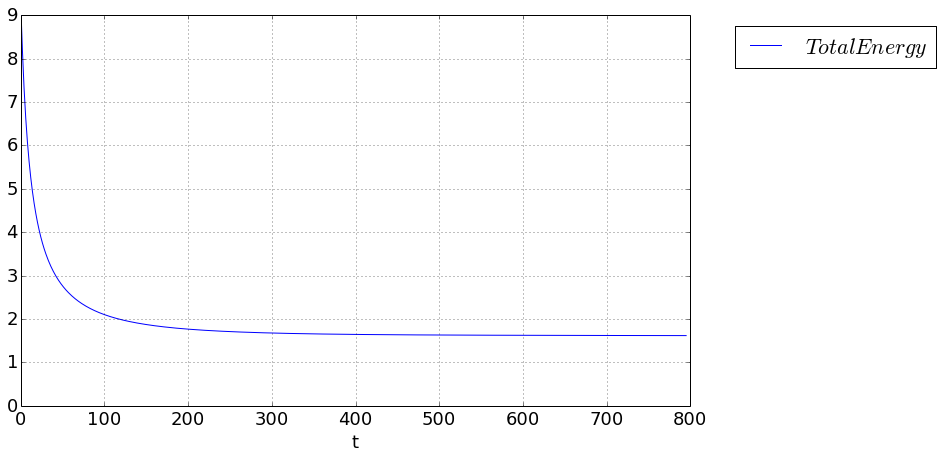

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot( instance.TotalEnergyHistory  ,
        '-' , label = '$Total Energy$' , linewidth=1.)



ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
ax.set_ylim( 0 , 9)
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();